In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
sns.set(palette='Set2')

In [7]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram

Скачаем <a href="https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis">данные</a> о клиентах некоторой торговой сети.

Цель задачи &mdash; кластеризовать клиентов с целью модификации продукта под разные типы пользовательских кластеров. Например, вместо того, чтобы тратиться на продвижение нового продукта каждому клиенту, можно продавать продукт только в том кластере, где клиенты с наибольшей вероятностью его купят.

In [8]:
data = pd.read_csv("marketing_campaign.csv", sep="\t")
data.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Посмотрим на диапазон дат регистрации

In [10]:
data["Dt_Customer"].min(), data["Dt_Customer"].max()

('01-01-2013', '31-12-2013')

Кажется, данные выгружены в конце 2014 года, соответственно, определим дату анализа

In [11]:
end_date = pd.Timestamp('2015-01-01')

Посчитаем для каждого клиента количество дней с момента регистрации

In [12]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"],  dayfirst=True)
data["usage_time"] = (end_date - data["Dt_Customer"]) / pd.Timedelta('1 day')
data["usage_time"]

0       849.0
1       299.0
2       498.0
3       325.0
4       347.0
        ...  
2235    567.0
2236    205.0
2237    341.0
2238    342.0
2239    808.0
Name: usage_time, Length: 2240, dtype: float64

Создадим следующие признаки:
* возраст клиента на основе даты рождения
* сумма покупок по всем категориям
* общее количество детей, сложив `Kidhome` и `Teenhome`
* на основе количества детей и семейного положения (`Marital_Status`) определите *предполагаемый* размер семьи
* средние траты клиента в день в период пользования сервисом, поделив суммарные траты на количество дней от даты регистрации (*см. примечание далее*)

In [13]:
data['Age'] = end_date.year - data['Year_Birth']

In [14]:
data['MntProducts'] = data['MntWines'] + data['MntFruits'] + data['MntGoldProds'] + data['MntMeatProducts'] + data['MntSweetProducts'] + data['MntSweetProducts']

In [15]:
data['n_child'] = data['Kidhome'] + data['Teenhome']

In [16]:
data['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [17]:
alone = ['Single', 'Divorced', 'Widow', 'Alone', 'Absurd']
data['fam_size'] = list(map(lambda x : 1 if x in alone else 2, data["Marital_Status"])) + data['n_child']

По гистограмме не совсем понятно, какую часть людей мы можем отнести к оттоку, а каких нет. Поэтому мы будем вычитать у всех из usage_time Recency.

Text(0.5, 1.0, 'График кол-во людей для каждого Recency')

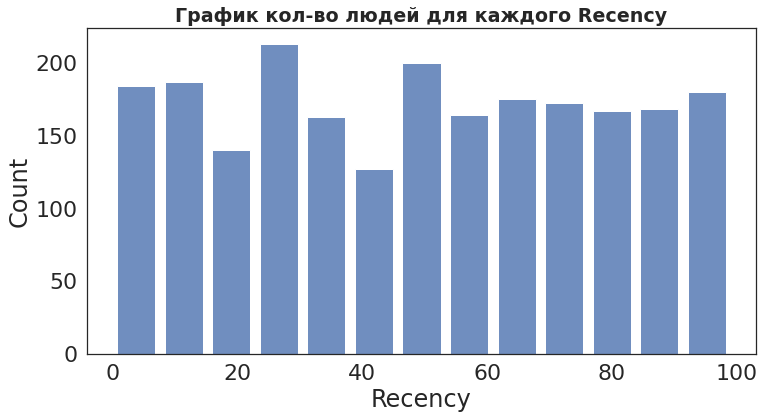

In [18]:
fig = plt.figure(figsize=(12, 6))
sns.set(style='white', font_scale = 2)
sns.histplot(data=data, x='Recency', alpha = 0.8, shrink=.8, multiple="dodge")
plt.title('График кол-во людей для каждого Recency', fontsize = 19, fontweight = 'bold')

Давайте оттоком будем считать тех людей, у которых 'Recency' > 50.

In [19]:
data['AveMnt'] = list(map(lambda x: data['MntProducts'][x] / data['usage_time'][x] 
                          if data['Recency'][x] <= 50 else 
                          data['MntProducts'][x] / (data['usage_time'][x] - data['Recency'][x]), range(len(data))))
data['AveMnt']

0       1.938053
1       0.086957
2       1.377510
3       0.141538
4       1.592885
          ...   
2235    2.499118
2236    2.979866
2237    4.884000
2238    2.318713
2239    0.211634
Name: AveMnt, Length: 2240, dtype: float64

Далее будем работать с признаками:
* возраст клиента
* предполагаемый размер семьи
* средние траты клиента в день
* `Income` &mdash; годовой доход клиента

Для начала уберем выбросы. Для этого я начертил вначале графики зависимостей от признаков, чтобы понять, где находятся эти выбросы. Чертить я тут не буду, чтобы не загромождать работу. 

In [20]:
print('Кол-во выбросов:', len(data) - len(data[(data['Income'] < 120000) & (data['Age'] < 100) & (data['AveMnt'] < 5)]))

Кол-во выбросов: 140


In [21]:
data = data[(data['Income'] < 120000) & (data['Age'] < 100) & (data['AveMnt'] < 6)]

In [22]:
features = ['Age', 'fam_size', 'AveMnt', 'Income']
new_data = data[features]

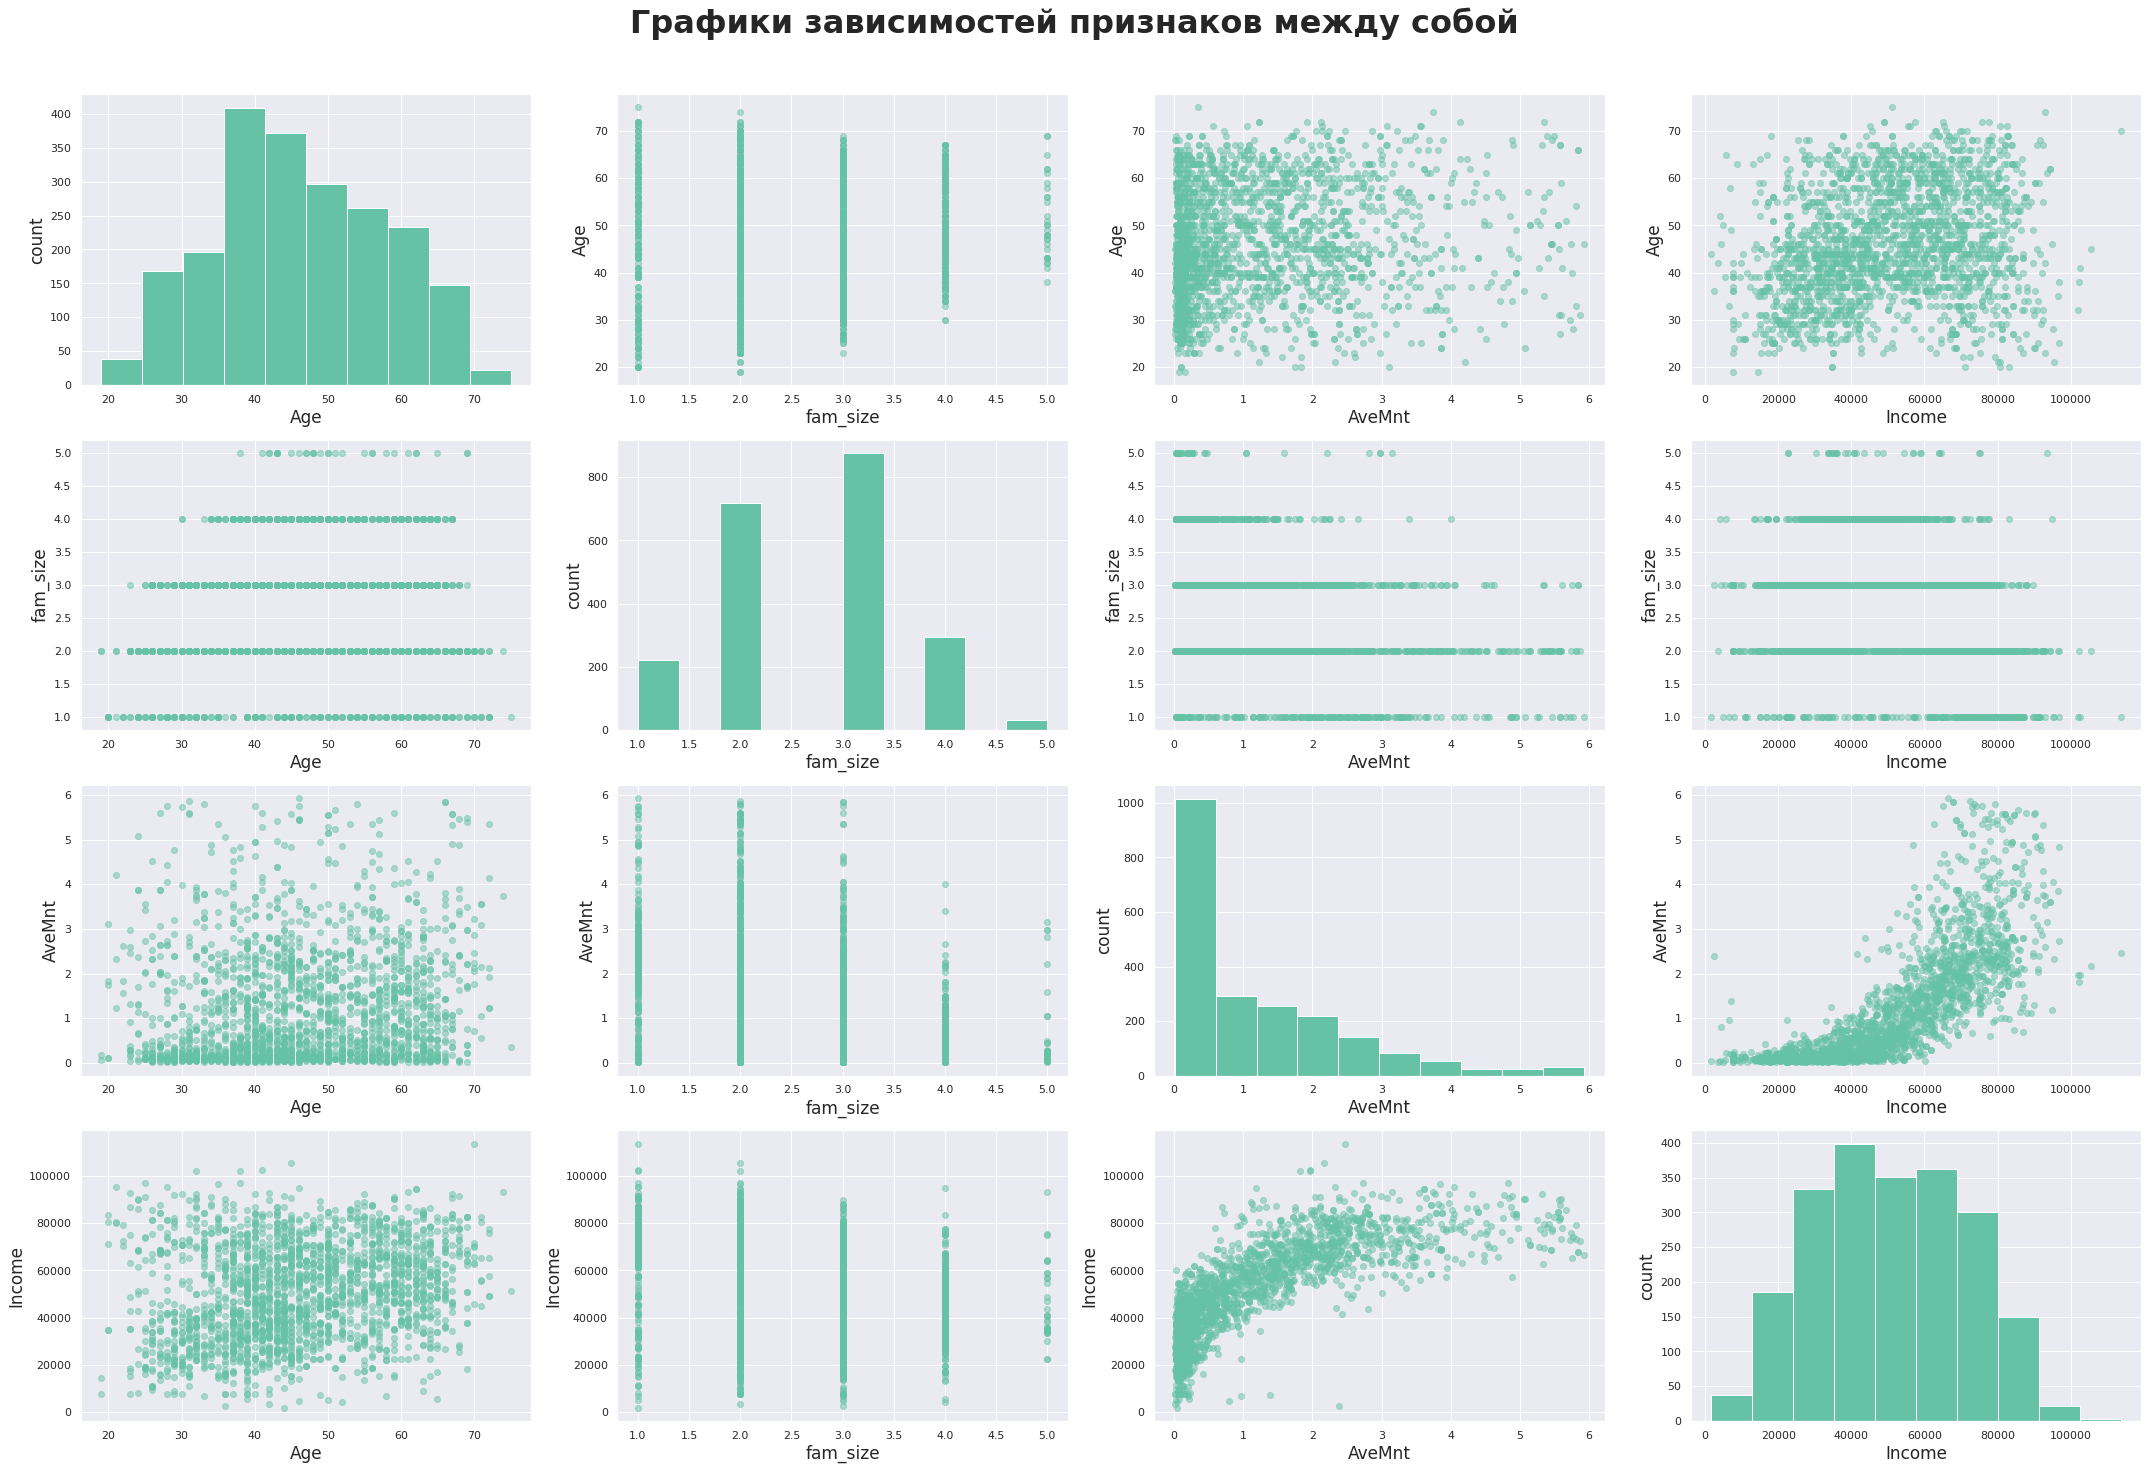

In [23]:
sns.set(palette='Set2')
fig = plt.figure(figsize=(30, 20))

for i in range(len(features)):
    for j in range(len(features)):
        plt.subplot(4, 4, i * len(features) + j + 1)
        if i == j:
            plt.hist(data[features[i]])
            plt.xlabel(features[i], fontsize = 17)
            plt.ylabel('count', fontsize = 17)
        else:
            plt.scatter(data[features[j]], data[features[i]], alpha = 0.5)
            plt.xlabel(features[j], fontsize = 17)
            plt.ylabel(features[i], fontsize = 17)

fig.suptitle('Графики зависимостей признаков между собой', fontsize = 32, fontweight = 'bold', y = 1.02)
plt.tight_layout()

По графикам мы можем заметить, что AveMnt и Income имеют явную зависимость зависимость. Поэтому один из этих признаков можно убрать. Уберем тогда Income.

In [24]:
new_data_plot = new_data[['Age', 'fam_size', 'Income']]

In [25]:
new_data_plot.isna().sum()

Age         0
fam_size    0
Income      0
dtype: int64

Как мы видими пропусков нет. Скорее всего они были вместе с выбросами.

Можем заметить, что некоторые признаки отличаются друг от друга в десятки раз. Так как мы будем использовать кластеризации, которые будут высчитывать расстояние между точками (или подбирать кластеры по окрестностям), нам важно, чтобы были масштабы близкими. Поэтому нам нужно сделать стандартизацию данных.

In [26]:
scaler_3 = StandardScaler()
new_data_stand = pd.DataFrame(scaler_3.fit_transform(new_data_plot))

In [27]:
new_data_stand.columns = ['Age', 'fam_size', 'Income']
new_data_stand

Age  fam_size    Income
0     1.021364 -1.808612  0.362208
1     1.279062  0.421055 -0.217390
2     0.334172 -0.693778  1.024415
3    -1.297910  0.421055 -1.185417
4    -1.040212  0.421055  0.369825
...        ...       ...       ...
2137  0.162374  0.421055  0.513815
2138  1.966254  2.650722  0.650974
2139 -1.040212 -1.808612  0.305349
2140  1.107263  0.421055  0.908044
2141  1.279062  1.535889  0.103271

[2142 rows x 3 columns]

Перейдем к кластеризации клиентов. Какой метод кластеризации будем использовать и почему? Как определить оптимальное количество кластеров или, в зависимости от метода, других гиперпараметров?

Не желателен DBScan, так как все данные плотные очень, судя по графикам, из-за чего есть вероятность получить либо мало кластеров (1 или 2), либо много изолированых точек. Иерархическую кластеризацию не будем использовать, так как она очень чувствительна к выбросам. KMeans, думаю, что является лучшим методом для решения в этой задаче, хотя бы потому, что гиперпараметры будет достаточно просто подобрать через Elbow method и Silhuette score

Выполните кластеризацию этим методом и подберите оптимальное количество гиперпараметров.

Text(0, 0.5, '$J(C_k)$')

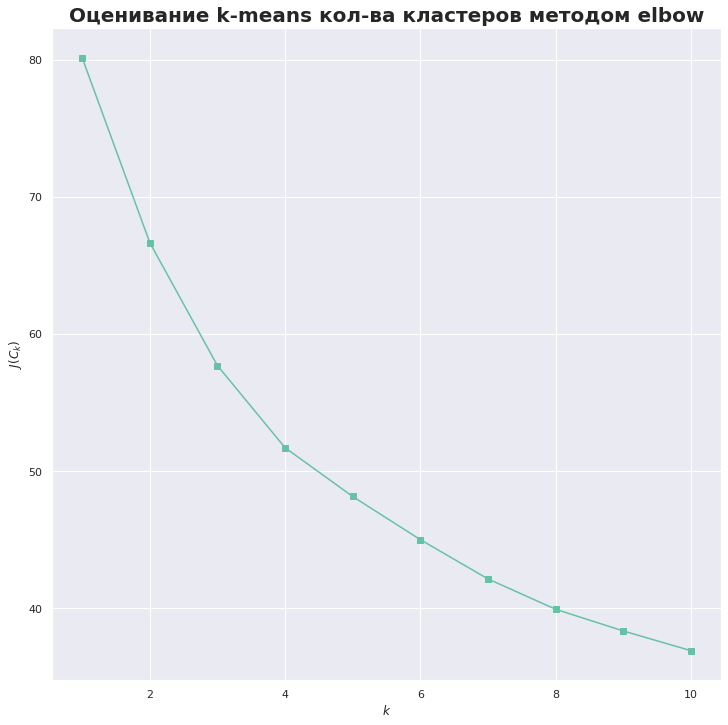

In [28]:
fig = plt.figure(figsize=(12, 12))

rg = range(1, 11)
inertia = []
for k in rg:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(new_data_stand)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.title('Оценивание k-means кол-ва кластеров методом elbow', fontsize = 20, fontweight = 'bold')
plt.plot(rg, inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

По графику видно, что после $k = 4$ происходит меньшее убывание, поэтому возьмем $k = 4$.

In [29]:
kmeans = KMeans(n_clusters = 4, random_state = 1)
predictions = kmeans.fit_predict(new_data_stand)

In [30]:
predictions

array([3, 1, 3, ..., 0, 1, 1], dtype=int32)

In [31]:
print(f'Количество элементов в каждом кластере - {np.unique(predictions, return_counts=True)[1]}')

Количество элементов в каждом кластере - [390 709 646 397]


For n_clusters = 3 The average silhouette_score is : 0.29438869968363063
For n_clusters = 4 The average silhouette_score is : 0.29950557581542575
For n_clusters = 5 The average silhouette_score is : 0.2958143242269608


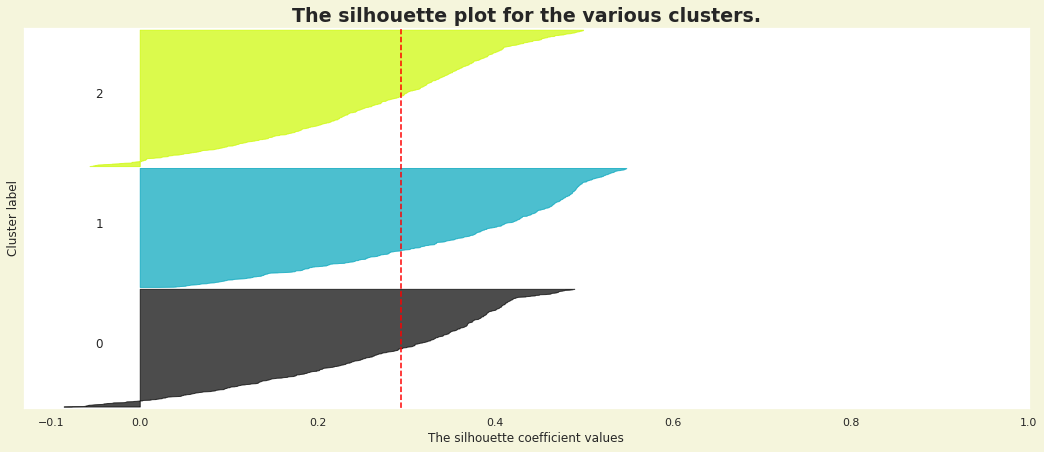

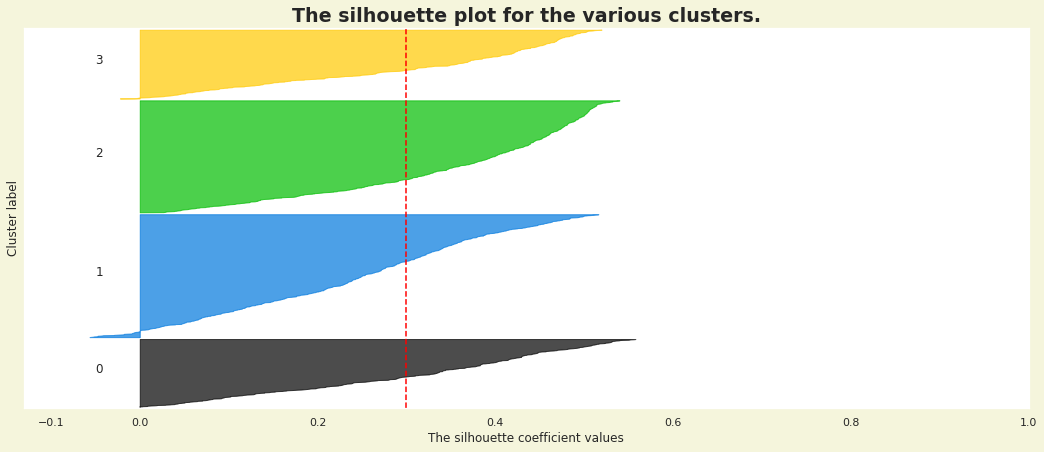

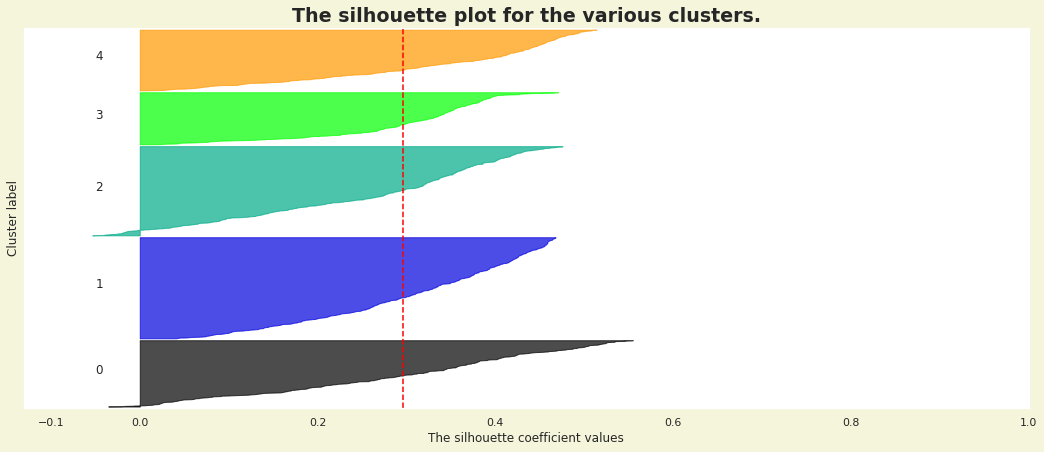

In [32]:
range_n_clusters =  [3, 4, 5]

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax.set_xlim([-0.13, 1])

    ax.set_ylim([0, len(new_data_stand) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(new_data_stand)

    silhouette_avg = silhouette_score(new_data_stand, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(new_data_stand, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  
    fig.patch.set_facecolor('beige')
    ax.patch.set_facecolor('white')
    ax.set_title("The silhouette plot for the various clusters.", fontsize = 19, fontweight = 'bold')
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

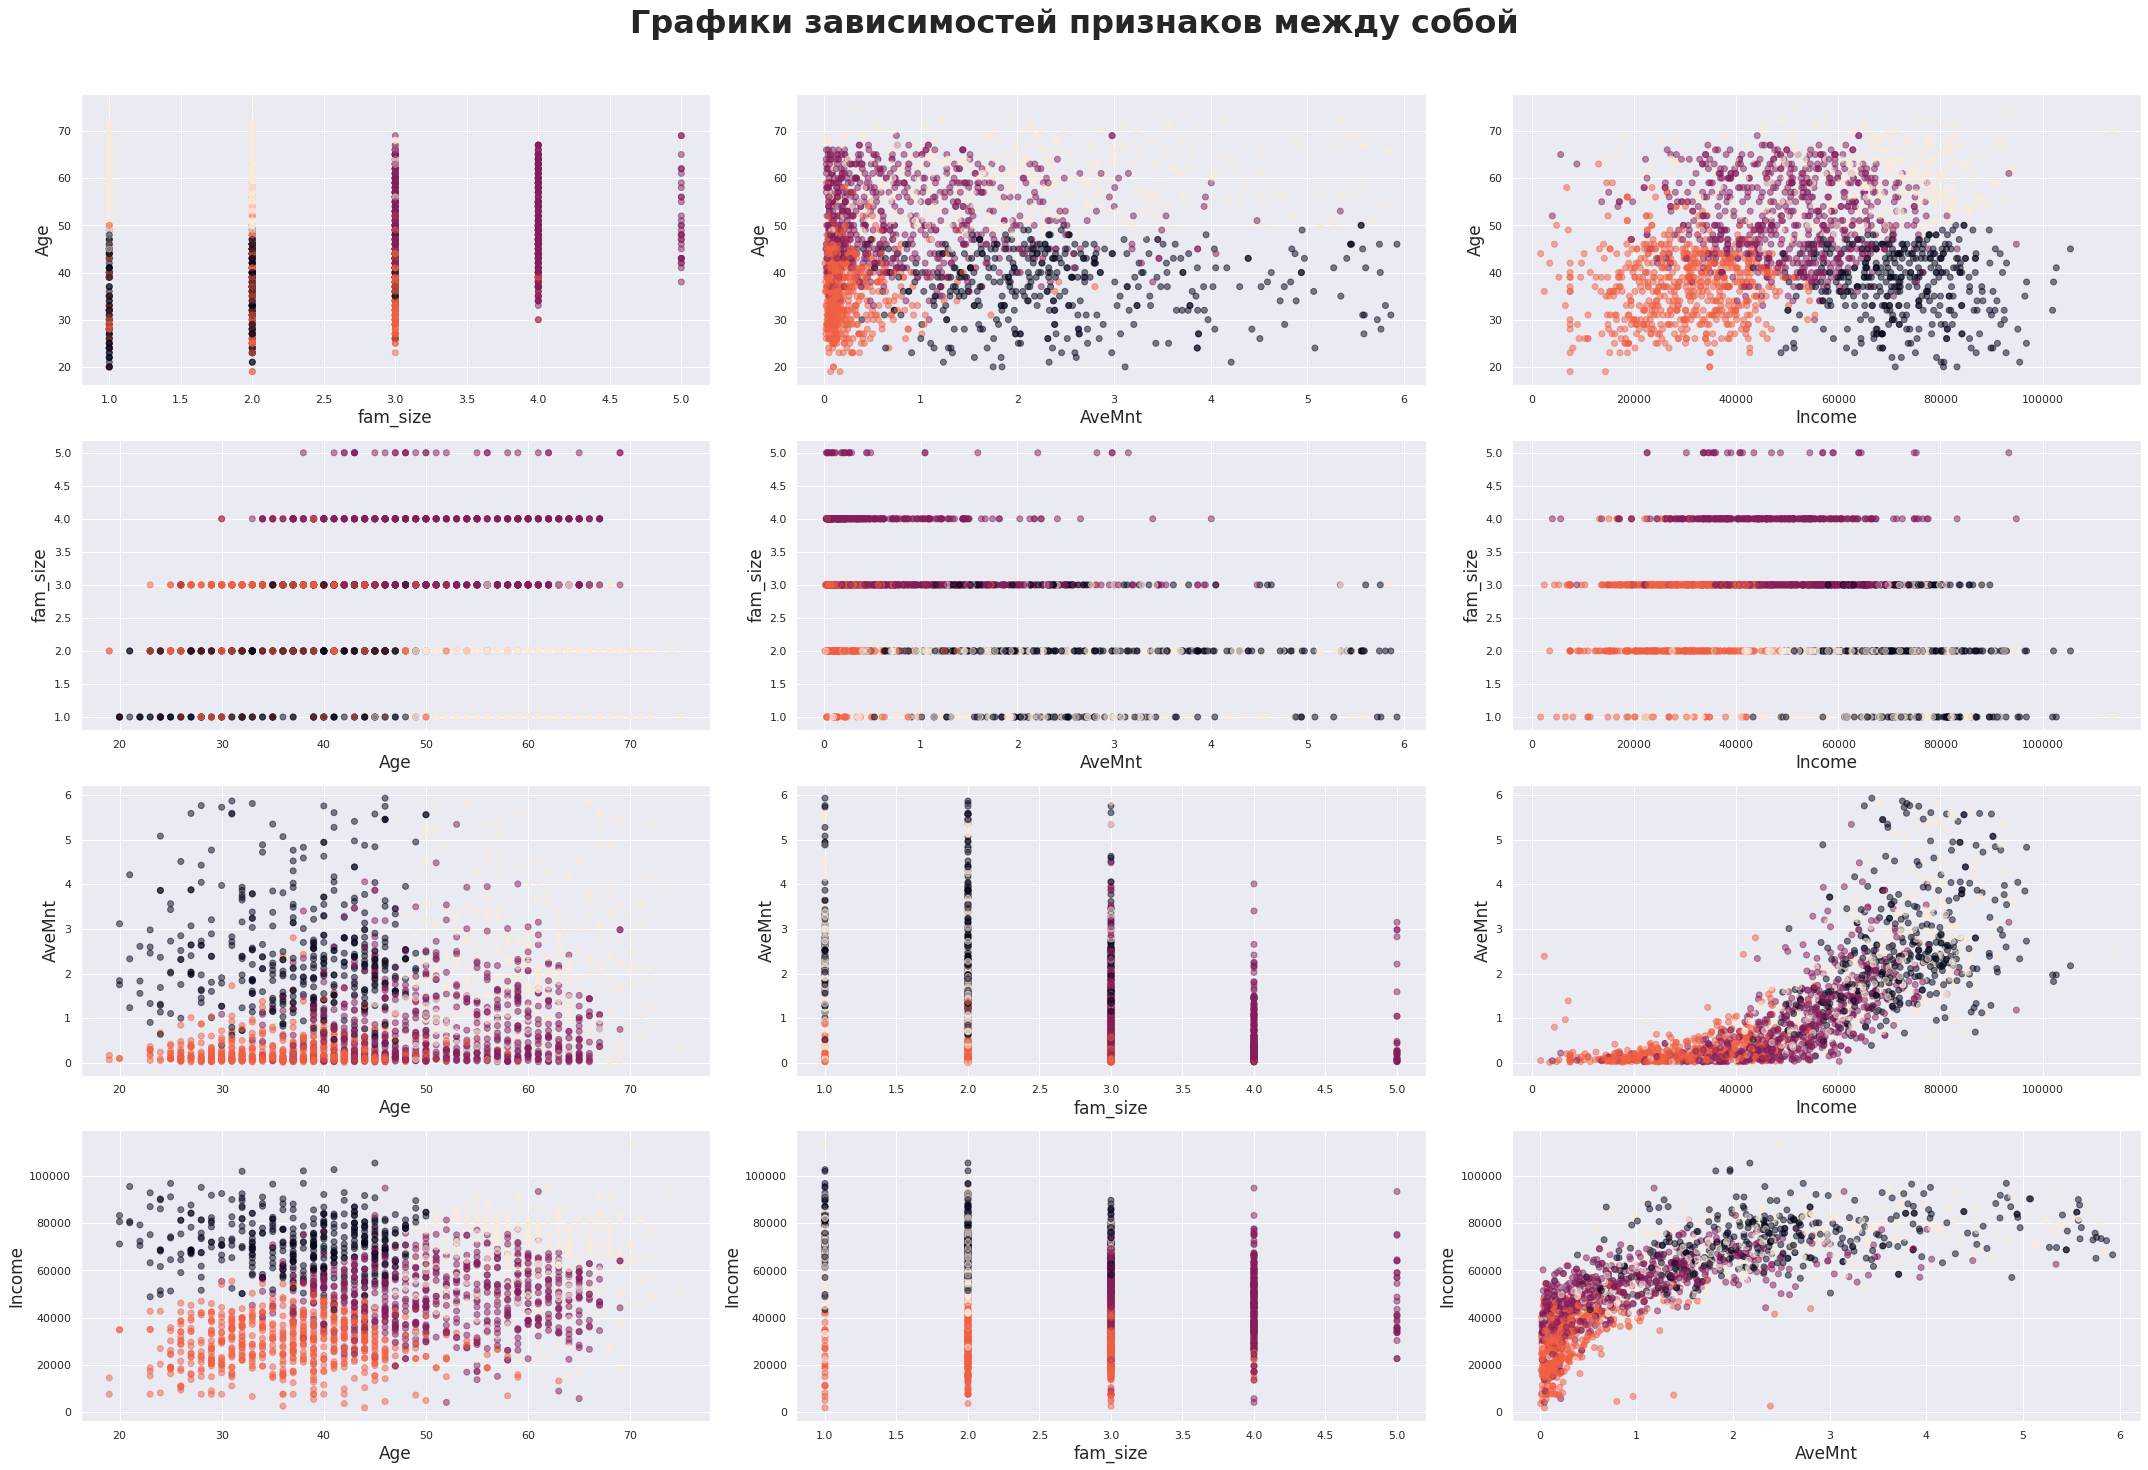

In [33]:
fig = plt.figure(figsize=(30, 20))
count = 1

for i in range(len(features)):
    for j in range(len(features)):
        if i == j:
            continue
            
        plt.subplot(4, 3, count)
        plt.scatter(data[features[j]], data[features[i]], alpha = 0.5, c = predictions)
        plt.xlabel(features[j], fontsize = 17)
        plt.ylabel(features[i], fontsize = 17)
        count += 1
        
fig.suptitle('Графики зависимостей признаков между собой', fontsize = 32, fontweight = 'bold', y = 1.02)
plt.tight_layout()

In [34]:
kmeans = KMeans(n_clusters = 4, random_state = 1)
predictions = kmeans.fit_predict(new_data_stand)
fig = px.scatter_3d(data[['Age', 'fam_size', 'Income']], x = 'Age', y = 'fam_size', z = 'Income', color = predictions)
fig.show()

NameError: name 'px' is not defined

Давайте прокомментируем каждый график:

(1 график) Силуэт показывает нам, что кластеризация прошла не очень хорошо, но нужно учитывать, что мы работаем с реальными данными, поэтому в целом неплохо. Значение силуэта получилось $0.3$, что в принципе неплохо для реальных данных. Также мы убедились, что при $k = 4$ кластеризация работает лучше, чем при дургих гиперпараметрах. 

(2 график) Если мы посмотри график зависимости Age и Income, то мы заметим, что кластеризация прошла очень даже неплохо. Все кластеры четко разделены и вроде в этой кластеризации присутствует логика. Так, например, у нас есть вот такие кластеры: (высокая зарплата, люди в возрасте), (низкая зарплата, люди в возрасте), (высокая зарплата, молодые), (низкая зарплата, молодые)

(3 график) В 3-D графике можно наглядно увидеть работу кластеризации, которую я попытался проинтерпретировать во 2 графике. 

Попробуйте также другие изученные методы кластеризации. Насколько лучше или хуже получится результат?

Давайте воспользуемся иерархическим методом. Попробуем разбить нашу выборку на кластеры и посмотри на значения силуэта. 

For n_clusters = 2 The average silhouette_score is : 0.24841218360283715
For n_clusters = 3 The average silhouette_score is : 0.2676817189827896
For n_clusters = 4 The average silhouette_score is : 0.26383683058802426
For n_clusters = 5 The average silhouette_score is : 0.2616017743677247


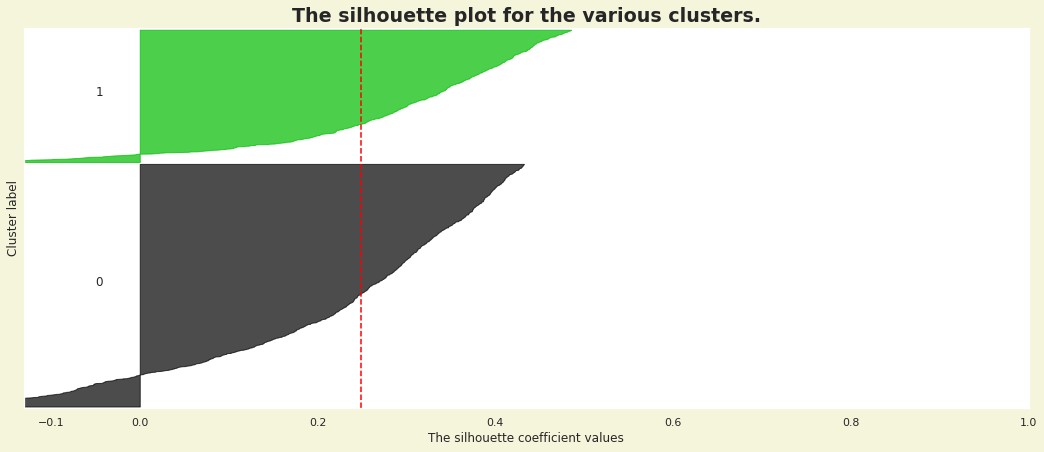

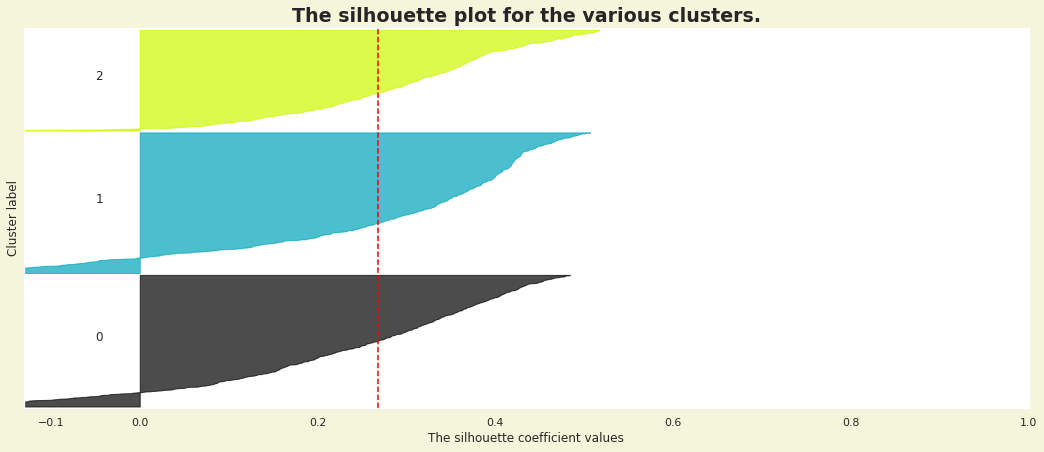

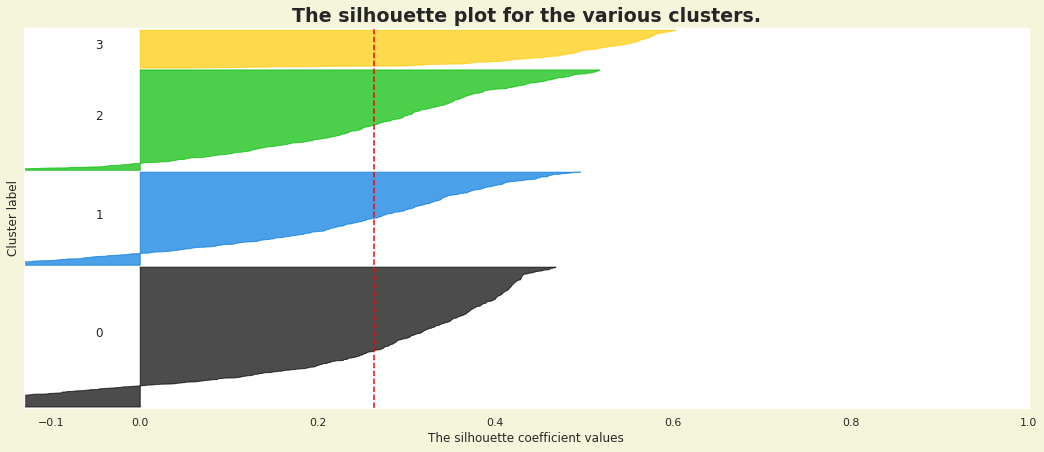

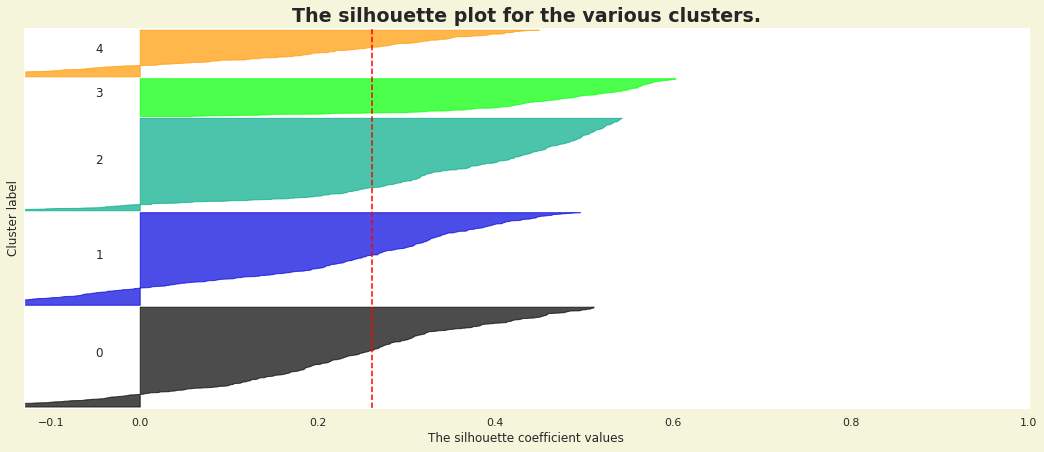

In [35]:
range_n_clusters =  [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    ax.set_xlim([-0.13, 1])

    ax.set_ylim([0, len(new_data_stand) + (n_clusters + 1) * 10])

    agglomerat = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerat.fit(new_data_stand)
    cluster_labels = agglomerat.labels_

    silhouette_avg = silhouette_score(new_data_stand, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(new_data_stand, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  
    fig.patch.set_facecolor('beige')
    ax.patch.set_facecolor('white')
    ax.set_title("The silhouette plot for the various clusters.", fontsize = 19, fontweight = 'bold')
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

Заметим, что иерархическая кластеризация работает хуже, чем k-means. Это можно понять по значениям силуэта. Также для иерархического лучше взять n_clusters = 3.

In [36]:
agglomerat = AgglomerativeClustering(n_clusters=3)
agglomerat.fit(new_data_stand)

AgglomerativeClustering(n_clusters=3)

Теперь посмотрим на то, как разбилась наша выборка.

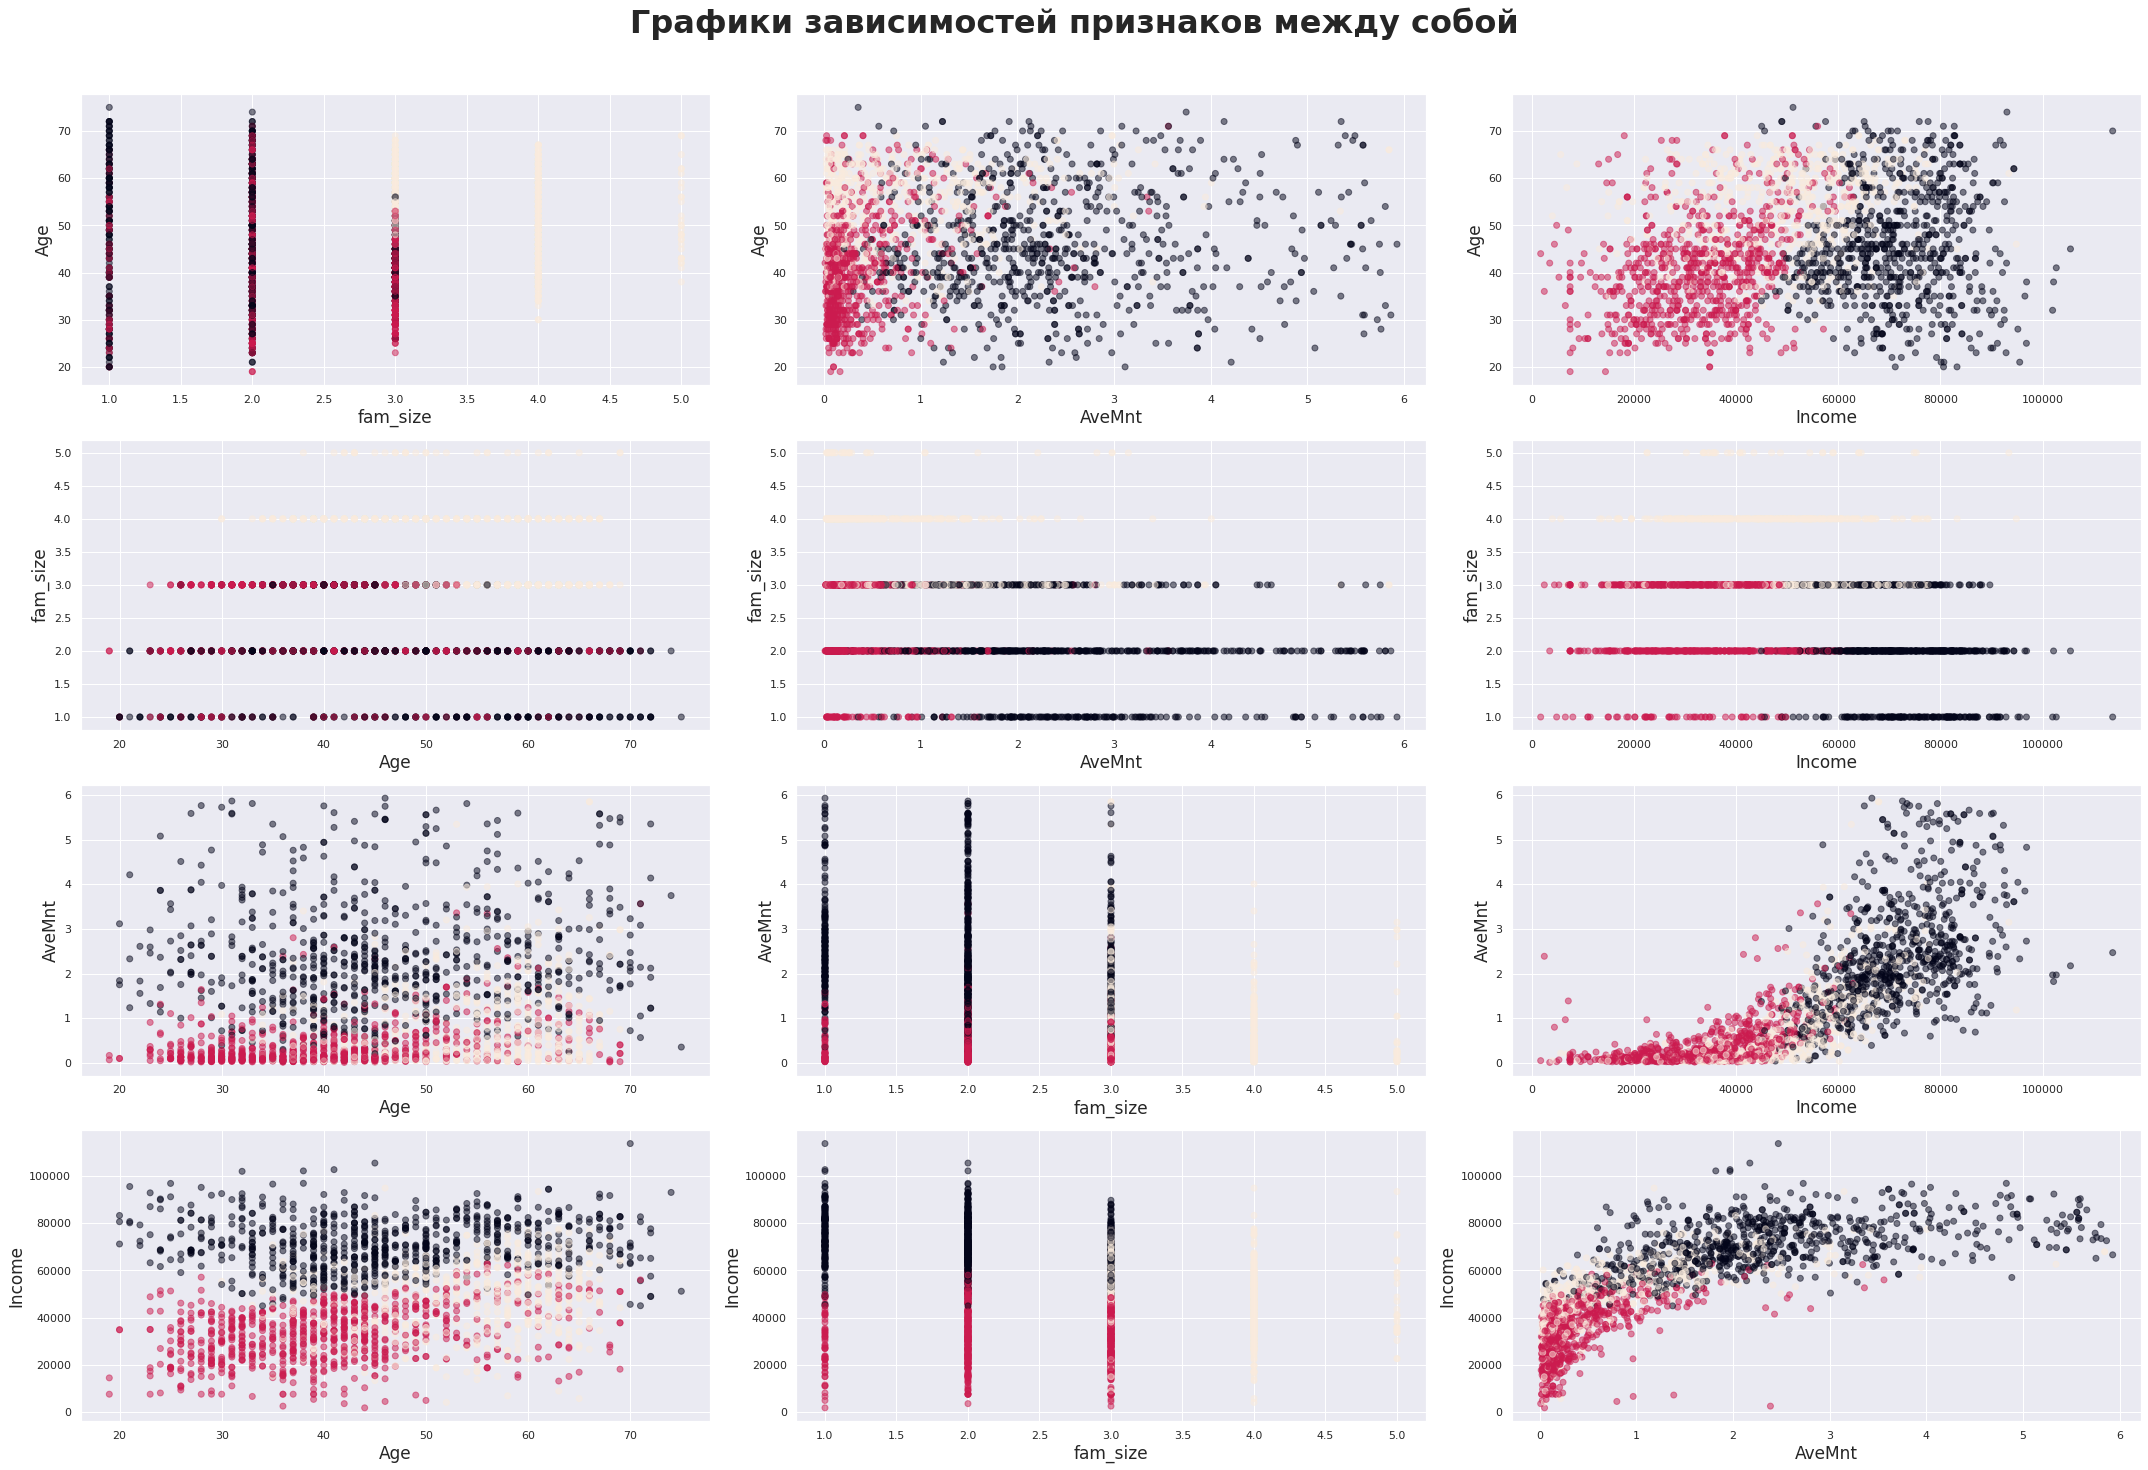

In [37]:
sns.set(palette='Set2')
fig = plt.figure(figsize=(30, 20))
count = 1

for i in range(len(features)):
    for j in range(len(features)):
        if i == j:
            continue
            
        plt.subplot(4, 3, count)
        plt.scatter(data[features[j]], data[features[i]], alpha = 0.5, c = agglomerat.labels_)
        plt.xlabel(features[j], fontsize = 17)
        plt.ylabel(features[i], fontsize = 17)
        count += 1
        
fig.suptitle('Графики зависимостей признаков между собой', fontsize = 32, fontweight = 'bold', y = 1.02)
plt.tight_layout()

Видно, что хорошо кластеризуются классы по размеру семьи, доходу, но присутствует бежевый класс (на рисунке), который как-будто лишний, так как его сложно интерпретировать, он очень сильно разбросан

In [38]:
children  = agglomerat.children_
distance = np.arange(children.shape[0])
n_dots = np.arange(2, children.shape[0] + 2)

linkage_matrix = np.column_stack(
    [children, np.exp(distance / 50), n_dots]).astype(float)

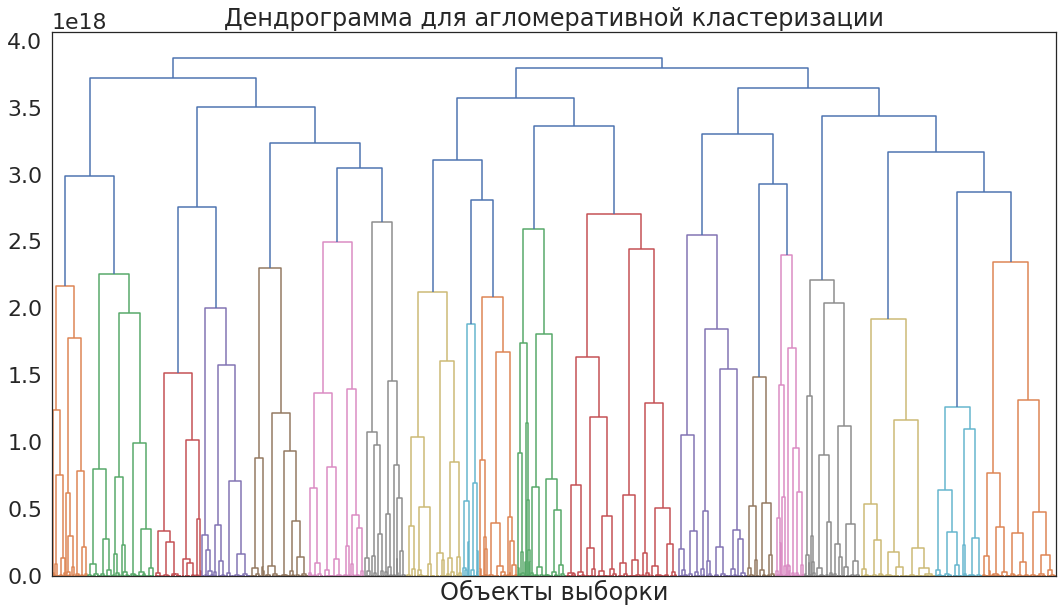

In [39]:
sns.set(style='white', font_scale = 2)
plt.figure(figsize=(18, 10))
dendrogram(linkage_matrix, labels=agglomerat.labels_, 
           no_labels=True,
          )
plt.title('Дендрограмма для агломеративной кластеризации')
plt.xlabel('Объекты выборки');

По дендограмме видно, что расстояние между кластерами маленькое, из-за чего очень сложно понять, как делить. Можно, конечно разделить на низком уровне, но получится слишком много кластеров

Теперь DBSCAN

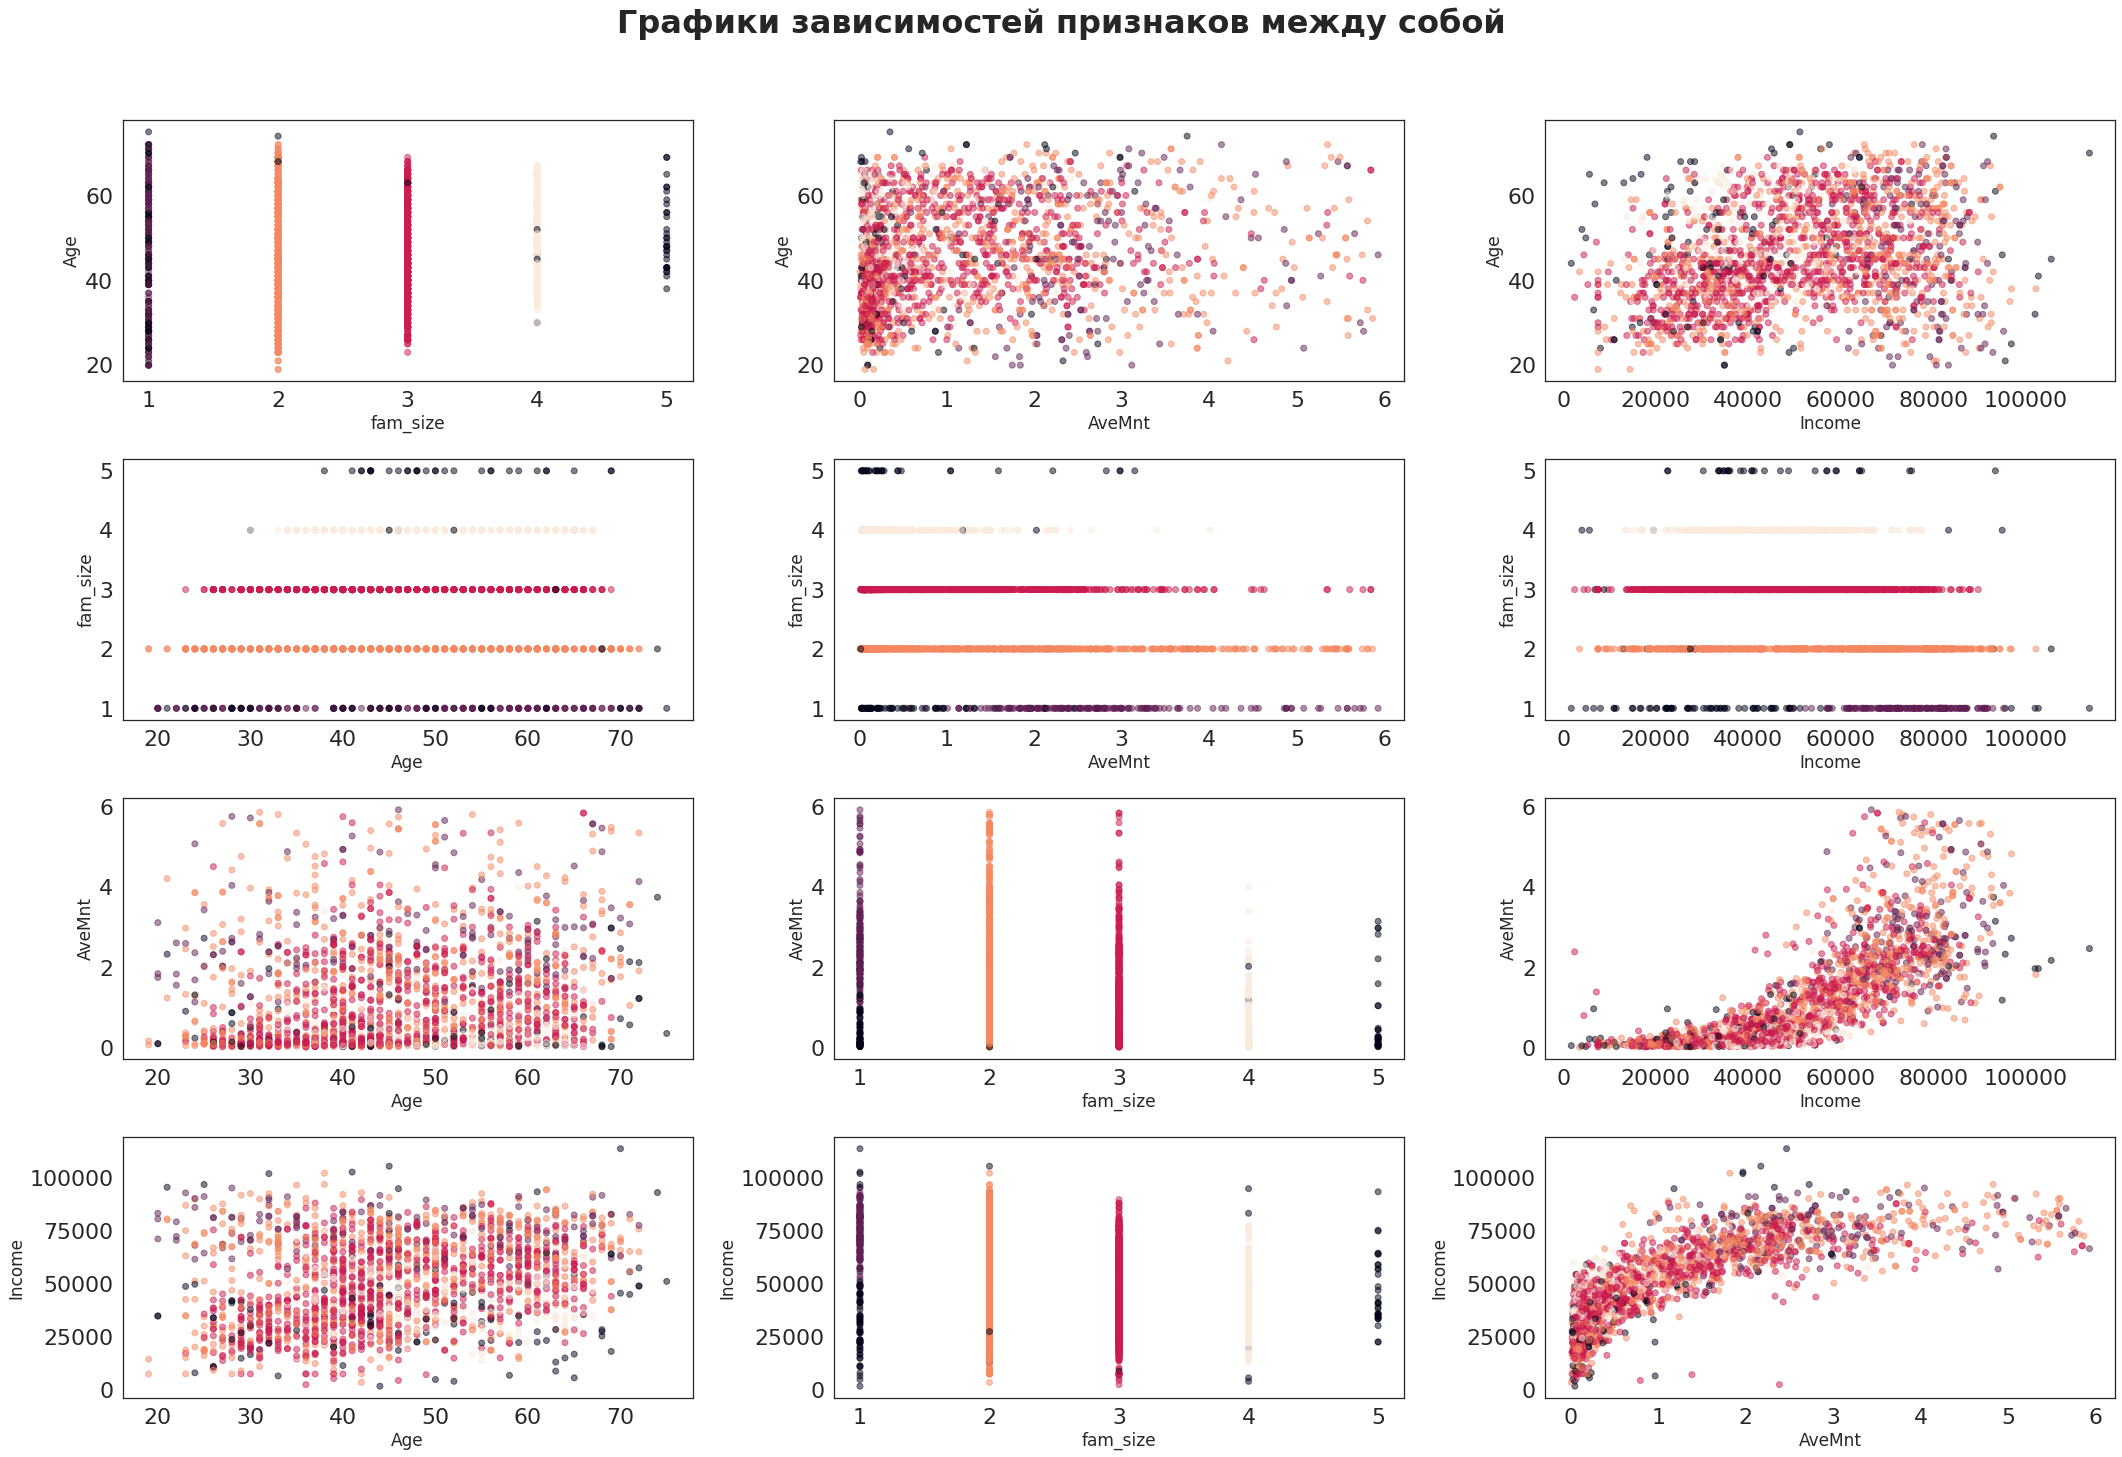

In [41]:
db_predict = DBSCAN(eps=0.65, min_samples=20).fit_predict(new_data_stand)
fig = plt.figure(figsize=(30, 20))
count = 1

for i in range(len(features)):
    for j in range(len(features)):
        if i == j:
            continue
            
        plt.subplot(4, 3, count)
        plt.scatter(data[features[j]], data[features[i]], alpha = 0.5, c = db_predict)
        plt.xlabel(features[j], fontsize = 17)
        plt.ylabel(features[i], fontsize = 17)
        count += 1
        
fig.suptitle('Графики зависимостей признаков между собой', fontsize = 32, fontweight = 'bold', y = 1.02)
plt.tight_layout()

In [42]:
np.unique(db_predict)

array([-1,  0,  1,  2,  3])

Долго мучаясь с подбором параметров для кластеризации DBScan, я пришел к следующему результату (eps = 0.65, min_samples = 20). DBScan разделил данные на 4 кластера. Посмотрев графики выше можно увидеть, что DBScan очень старается делить данные по признаку fam_size, а остальные признаки как-будто не берет в счет, потому что на остальных графиках творится хаос. Это может быть связано с тем, что данные лежат очень плотно друг к другу, из-за чего очень сложно подобрать такие параметры, чтобы создать плюс-минус адекватные кластеры.

**Вывод:**

1) Данные очень трудно кластеризовать, по тем методам, которые мы изучили. Это видно по значениям силуэта и графикам. Подробности про то, как кластеризовали наши методы, надо смотреть под графиками.

2) Из всех методов, которые мы использовали, как оказалось, самым лучшим был k-means. Хуже всего отработал DBSCAN, так как трудно подобрать гиперпараметры. Иерархический метод отработал чуть хуже, чем k-means. 